# Necessary Imports

In [ ]:
# Install required libraries
%pip install diffusers datasets transformers accelerate
%pip install --quiet einops

# Standard imports
import os
import shutil
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.cuda.amp import GradScaler

# Diffusers imports
import diffusers
from diffusers import DDPMScheduler, UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup

print(f"Diffusers version: {diffusers.__version__}")
print(f"Torch version: {torch.__version__}")

Diffusers version: 0.35.2
Torch version: 2.9.0+cu126


In [ ]:
%pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 57.5 MB/s eta 0:00:00


# Logging Metrics on WandB

In [ ]:
%pip install wandb

import wandb
wandb.login()
# API KEY = 79017ec61bb0be5ea863c5ac5addcfcb554f75e5


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anirudmohan2002 (challenger) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Moving Dataset to the Local Folder for faster runs

In [ ]:
import shutil
import os

# --- CONFIG ---
DRIVE_DATA_DIR = "/content/drive/MyDrive/SegGuidedDiff/brats_final_split" # Where it is now
LOCAL_DATA_DIR = "/content/dataset"        # Where we want it (Fast Local Disk)

if not os.path.exists(LOCAL_DATA_DIR):
    print(f"Copying data from Drive to Local Disk (This speeds up training 10x)...")
    shutil.copytree(DRIVE_DATA_DIR, LOCAL_DATA_DIR)
    print("Copy complete! Training will now be fast.")
else:
    print("Data already on local disk.")

Copying data from Drive to Local Disk (This speeds up training 10x)...
Copy complete! Training will now be fast.


# Training Config

In [ ]:
class TrainingConfig:
    # --- Project Paths ---
    # Ensure these point to the output of your splitting script
    TRAIN_IMG_DIR = "/content/dataset/train/flair"
    TRAIN_MASK_DIR = "/content/dataset/train/mask"
    VAL_IMG_DIR = "/content/dataset/val/flair"
    VAL_MASK_DIR = "/content/dataset/val/mask"

    OUTPUT_DIR: str = "/content/drive/MyDrive/SegGuidedDiff/sample_output"

    # --- Model Params (Matches main.py defaults) ---
    model_type: str = "DDPM"
    image_size: int = 256
    train_batch_size: int = 64
    eval_batch_size: int = 64
    num_epochs: int = 200
    learning_rate: float = 1e-4
    lr_warmup_steps: int = 500
    save_image_epochs: int = 10
    save_model_epochs: int = 10
    mixed_precision: str = "fp16"

    # --- Segmentation Guidance Options ---
    segmentation_guided: bool = True
    segmentation_channel_mode: str = "single" # STRICT: eval.py only supports 'single'
    num_segmentation_classes: int = 5         # 0:BG, 1:CSF, 2:GM, 3:WM, 4:Tumor
    use_ablated_segmentations: bool = True    # Enable MAT
    ablation_prob: float = 0.3

    # --- Unused but required fields ---
    gradient_accumulation_steps: int = 1
    push_to_hub: bool = False
    hub_private_repo: bool = False
    overwrite_output_dir: bool = True
    seed: int = 0
    class_conditional: bool = False
    resume_epoch: int = None


config = TrainingConfig()
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
print("Training Configuration Loaded.")

Training Configuration Loaded.


# Helper Functions to Label Masks

In [ ]:
def ablate_masks(segs, config):
    """
    Randomly removes class label(s) from segs with some probability.
    """
    # The logic assumes classes are encoded as values {1/255, 2/255, ...}
    # We iterate through possible classes (1 to num_classes-1)
    # We skip 0 (Background) because we don't ablate background

    # Generate a random boolean list of which classes to remove
    # (config.num_segmentation_classes - 1) gives us the count of non-BG classes
    class_removals = (torch.rand(config.num_segmentation_classes - 1) < 0.5).int().bool().tolist()

    for class_idx, remove_class in enumerate(class_removals):
        if remove_class:
            segs[(255 * segs).int() == class_idx + 1] = 0
    return segs


In [ ]:
def convert_segbatch_to_multiclass(shape, segmentations_batch, config, device):
    """
    Combines different segmentation maps into one single-channel map.
    """
    segs = torch.zeros(shape).to(device)


    if isinstance(segmentations_batch, dict):
        for k, seg in segmentations_batch.items():
            if k.startswith("seg_"):
                seg = seg.to(device)
                # Overwrite 0s with new segmentations
                segs[segs == 0] = seg[segs == 0]
    else:
        # Fallback if direct tensor is passed
        segs = segmentations_batch.to(device)

    if config.use_ablated_segmentations:
        segs = ablate_masks(segs, config)

    return segs


In [ ]:
def add_segmentations_to_noise(noisy_images, batch, config, device):
    """
    Concatenates the single-channel mask to the noisy image.
    """
    if config.segmentation_channel_mode == "single":
        # Create shape: (Batch, 1, H, W)
        multiclass_masks_shape = (noisy_images.shape[0], 1, noisy_images.shape[2], noisy_images.shape[3])

        # Get the processed (and potentially ablated) mask
        segs = convert_segbatch_to_multiclass(multiclass_masks_shape, batch, config, device)

        # Concatenate: (Batch, 1, H, W) + (Batch, 1, H, W) -> (Batch, 2, H, W)
        noisy_images = torch.cat((noisy_images, segs), dim=1)

    else:
        raise NotImplementedError("Only 'single' channel mode is supported by the researchers' code.")

    return noisy_images

# Dataset Loader Class

In [ ]:
# --- CELL 4: BraTS Dataset (Final Explicit Map) ---

class BraTSDataset(Dataset):
    def __init__(self, img_dir, mask_dir, config, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.config = config
        self.filenames = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])

        # --- YOUR EXACT MAPPING ---
        # We map your pixel values to the Class IDs (0-4) required by the model.
        self.mapping = {
            0: 0,      # Background

            # Tumor (You confirmed this)
            76: 4,

            # Healthy Tissues (Mapped to 1, 2, 3)
            29: 1,
            150: 2,
            226: 3
        }

        print(f"Dataset initialized with Map: {self.mapping}")

        # Transforms
        self.img_transform = transforms.Compose([
            transforms.Resize((config.image_size, config.image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

        self.mask_transform = transforms.Compose([
            transforms.Resize((config.image_size, config.image_size), interpolation=transforms.InterpolationMode.NEAREST),
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]

        # 1. Load
        img_path = os.path.join(self.img_dir, fname)
        mask_path = os.path.join(self.mask_dir, fname)

            # Define custom paths for the sanity check
        # img_path = "/content/drive/MyDrive/SegGuidedDiff/brats_final_split/train/flair/BraTS2021_00000_slice_055.png"
        # mask_path = "/content/drive/MyDrive/SegGuidedDiff/brats_final_split/train/mask/BraTS2021_00000_slice_055.png"


        image = Image.open(img_path).convert("L")
        image = self.img_transform(image)

        mask = Image.open(mask_path).convert("L")
        mask = self.mask_transform(mask)
        mask_arr = np.array(mask)

        # 2. MAP PIXELS TO CLASSES (0, 1, 2, 3, 4)
        new_mask = np.zeros_like(mask_arr, dtype=np.float32)

        for src_val, target_cls in self.mapping.items():
            new_mask[mask_arr == src_val] = target_cls

        # 3. Apply MAT (Ablation)
        # If we ablate, we find Class 4 (Tumor) and set it to 0 (BG)
        if self.config.use_ablated_segmentations and torch.rand(1) < self.config.ablation_prob:
            new_mask[new_mask == 4] = 0

        # 4. ENCODE (Strict 1/255 format)
        # This converts 1->0.0039, 4->0.0156, etc.
        new_mask = new_mask / 255.0

        # Convert to Tensor (1, H, W)
        mask_tensor = torch.from_numpy(new_mask).unsqueeze(0)

        return {"images": image, "seg_mask": mask_tensor}

NameError: name 'Dataset' is not defined

***Sanity Check***

Dataset initialized with Map: {0: 0, 76: 4, 29: 1, 150: 2, 226: 3}

--- SHAPE CHECK ---
Image Shape: torch.Size([4, 1, 256, 256]) (Batch, 1, H, W)
Mask Shape:  torch.Size([4, 1, 256, 256])  (Batch, 1, H, W) <--- MUST BE 1 CHANNEL

--- VALUE CHECK (What the model sees) ---
Raw Float Values: [0.0, 0.003921568859368563, 0.007843137718737125, 0.0117647061124444, 0.01568627543747425]
Recovered Classes: [0, 1, 2, 3, 4]

SUCCESS: Tumor Class (4) is present and encoded correctly!


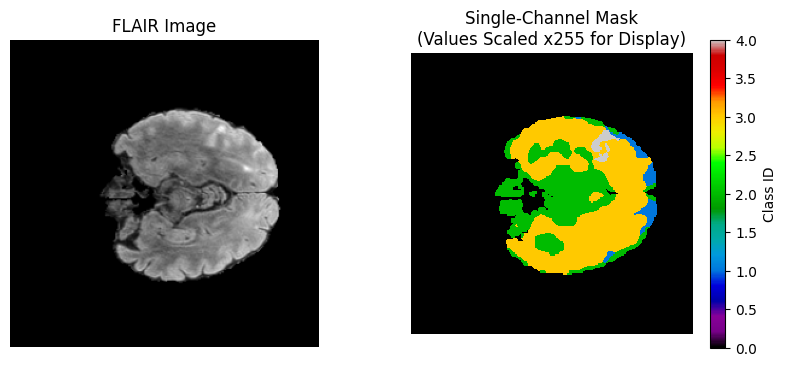

In [ ]:
# --- CELL 5: Strict Sanity Check ---

try:
    # Create a temporary loader
    train_ds = BraTSDataset(config.TRAIN_IMG_DIR, config.TRAIN_MASK_DIR, config)
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)

    # Fetch one batch
    batch = next(iter(train_loader))
    images = batch["images"]
    masks = batch["seg_mask"]

    print(f"\n--- SHAPE CHECK ---")
    print(f"Image Shape: {images.shape} (Batch, 1, H, W)")
    print(f"Mask Shape:  {masks.shape}  (Batch, 1, H, W) <--- MUST BE 1 CHANNEL")

    # --- VALUE CHECK ---
    # We pick the first mask in the batch
    sample_mask = masks[0]

    # Get unique float values actually present in the tensor
    unique_floats = torch.unique(sample_mask)
    print(f"\n--- VALUE CHECK (What the model sees) ---")
    print(f"Raw Float Values: {unique_floats.tolist()}")

    # Convert back to integers to verify classes
    # Logic: int(float_val * 255)
    recovered_classes = (unique_floats * 255).round().int().tolist()
    print(f"Recovered Classes: {recovered_classes}")

    if 4 in recovered_classes:
        print("\nSUCCESS: Tumor Class (4) is present and encoded correctly!")
    else:
        print("\nWARNING: Tumor Class (4) not found in this specific random batch. Try running again.")

    # --- VISUALIZATION ---
    # We multiply by 255 just for display purposes so it's not pitch black
    display_mask = (sample_mask * 255).squeeze().numpy()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(images[0].squeeze(), cmap='gray')
    plt.title("FLAIR Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(display_mask, cmap='nipy_spectral', interpolation='nearest')
    plt.title("Single-Channel Mask\n(Values Scaled x255 for Display)")
    plt.colorbar(label="Class ID")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"ERROR: {e}")

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

# --- CONFIG ---
# Make sure this points to your NEW updated dataset
MASK_DIR = config.TRAIN_MASK_DIR
NUM_FILES_TO_SCAN = 50

print(f"Scanning {NUM_FILES_TO_SCAN} random masks in {MASK_DIR}...")

mask_files = [f for f in os.listdir(MASK_DIR) if f.endswith('.png')]
if len(mask_files) > NUM_FILES_TO_SCAN:
    mask_files = np.random.choice(mask_files, NUM_FILES_TO_SCAN, replace=False)

all_values = set()

for fname in tqdm(mask_files):
    path = os.path.join(MASK_DIR, fname)
    # We convert to "L" (Grayscale) because that's what the model reads
    mask = np.array(Image.open(path).convert("L"))
    unique = np.unique(mask)
    all_values.update(unique)

print(f"\n--- RESULTS ---")
print(f"Unique Pixel Values Found: {sorted(list(all_values))}")

Scanning 50 random masks in /content/dataset/train/mask...


  0%|          | 0/50 [00:00<?, ?it/s]


--- RESULTS ---
Unique Pixel Values Found: [np.uint8(0), np.uint8(29), np.uint8(76), np.uint8(150), np.uint8(226)]


***Visualising Different Classes in an image***

Mask Path  /content/dataset/train/mask/BraTS2021_00000_slice_055.png
Inspecting: BraTS2021_00000_slice_055.png
Values in this file: [  0  29  76 150 226]


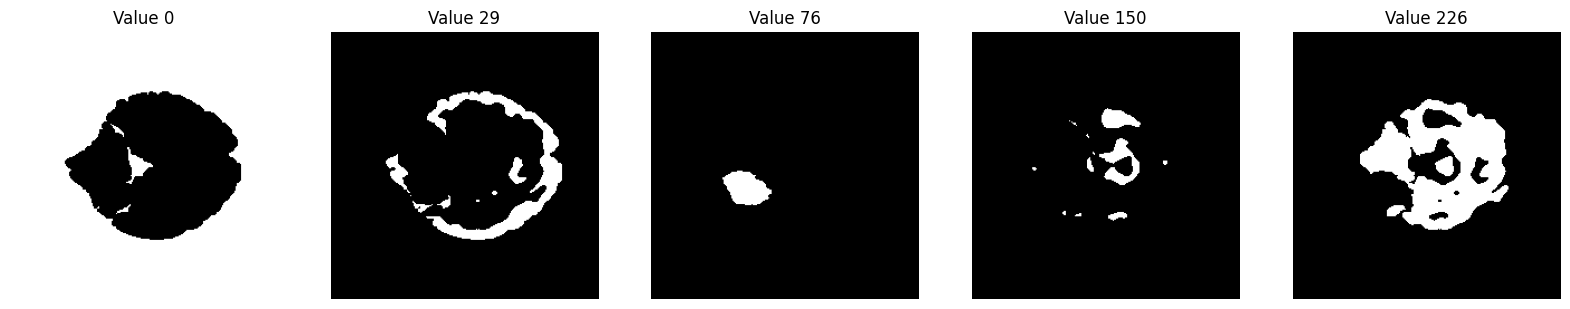

In [ ]:
import matplotlib.pyplot as plt
import random

# Pick a file
mask_files = sorted([f for f in os.listdir(config.TRAIN_MASK_DIR) if f.endswith('.png')])
# Try a few indices (10, 20, 30) until you find one with a tumor
test_idx = 51
mask_path = os.path.join(config.TRAIN_MASK_DIR, mask_files[test_idx])
print('Mask Path ', mask_path)

mask_arr = np.array(Image.open(mask_path).convert("L"))
unique_vals = np.unique(mask_arr)

print(f"Inspecting: {mask_files[test_idx]}")
print(f"Values in this file: {unique_vals}")

# Plot
fig, axes = plt.subplots(1, len(unique_vals), figsize=(20, 4))

if len(unique_vals) == 1:
    axes = [axes] # Handle single value case

for i, val in enumerate(unique_vals):
    binary_map = (mask_arr == val)
    axes[i].imshow(binary_map, cmap='gray')
    axes[i].set_title(f"Value {val}")
    axes[i].axis('off')

plt.show()

# Model Definition

In [ ]:
in_channels = 1
if config.segmentation_guided:
    if config.segmentation_channel_mode == "single":
        in_channels += 1
    else:
        raise NotImplementedError("Only single channel mode supported.")

print(f"Model Input Channels: {in_channels} (1 Image + 1 Mask)")

# 2. Define U-Net"
model = UNet2DModel(
    sample_size=config.image_size,
    in_channels=in_channels,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D", "DownBlock2D", "DownBlock2D",
        "DownBlock2D", "AttnDownBlock2D", "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D", "AttnUpBlock2D", "UpBlock2D",
        "UpBlock2D", "UpBlock2D", "UpBlock2D"
    ),
)

# 3. Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = nn.DataParallel(model) # Wraps model to match training.py structure
model.to(device)
model = torch.compile(model) # Assign the compiled model back

# 4. Scheduler & Optimizer
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)


print("Model, Scheduler, and Optimizer initialized.")

Model Input Channels: 2 (1 Image + 1 Mask)
Model, Scheduler, and Optimizer initialized.


# Training Loop

In [ ]:
import torch
import gc

# Force Garbage Collection
gc.collect()


# Clear PyTorch Cache
torch.cuda.empty_cache()

# Print Status
print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU Memory Reserved:  {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

GPU Memory Allocated: 0.43 GB
GPU Memory Reserved:  0.43 GB


***Wandb Logger Function***

In [ ]:
# --- CELL 6.5: WandB Image Logger (Fixed: DDIM + Histogram Matching) ---
from torchmetrics.image import StructuralSimilarityIndexMeasure
from diffusers import DDIMScheduler
from skimage.exposure import match_histograms
import numpy as np

def log_validation_images(model, scheduler, val_ds, config, device, epoch):
    print(f"Generating Visuals & SSIM (Epoch {epoch})...")

    # Init SSIM metric
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    # 1. Pick tumor sample (Deterministic)
    sample_idx = 0
    for i in range(len(val_ds)):
        if val_ds[i]["seg_mask"][0].max() > 0.015:
            sample_idx = i
            break

    batch = val_ds[sample_idx]
    real_img = batch["images"].unsqueeze(0).to(device)
    real_mask = batch["seg_mask"].unsqueeze(0).to(device)

    # 2. Ablate Mask
    healthy_mask = real_mask.clone()
    healthy_mask[real_mask > 0.014] = 0

    # 3. Generate (Using DDIM for Stability)
    # Handle unwrapping
    unet_to_use = model.module if hasattr(model, 'module') else model
    if hasattr(unet_to_use, "_orig_mod"): unet_to_use = unet_to_use._orig_mod

    # Switch to DDIM for inference only
    inference_scheduler = DDIMScheduler.from_config(scheduler.config)
    inference_scheduler.set_timesteps(50)

    generator = torch.Generator(device='cpu').manual_seed(42)
    image = torch.randn(1, 1, config.image_size, config.image_size, generator=generator).to(device)

    for t in inference_scheduler.timesteps:
        model_input = torch.cat([image, healthy_mask], dim=1)
        with torch.no_grad():
            noise_pred = unet_to_use(model_input, t).sample
        image = inference_scheduler.step(noise_pred, t, image).prev_sample

    # --- FIX: HISTOGRAM MATCHING FOR SSIM ---
    # 1. Convert to Numpy [0, 1]
    gen_np = (image[0,0].cpu().numpy() / 2 + 0.5).clip(0, 1)
    real_np = (real_img[0,0].cpu().numpy() / 2 + 0.5).clip(0, 1)

    # 2. Match Histograms (Fixes brightness mismatch)
    gen_matched = match_histograms(gen_np, real_np, channel_axis=None)

    # 3. Back to Tensor for SSIM
    gen_norm = torch.from_numpy(gen_matched).unsqueeze(0).unsqueeze(0).to(device)
    real_norm = torch.from_numpy(real_np).unsqueeze(0).unsqueeze(0).to(device)

    # 4. Create ROI Mask (Healthy regions only)
    roi_mask = (real_mask[:, 0:1, :, :] < 0.015).float()

    # 5. Mask & Score
    gen_masked = gen_norm * roi_mask
    real_masked = real_norm * roi_mask
    score = ssim(gen_masked, real_masked)

    # --- LOGGING ---
    mask_disp = (healthy_mask[0,0].cpu().numpy() * 255).astype(np.uint8) * 50

    wandb.log({
        "val_ssim": score.item(),
        "epoch": epoch,
        "Validation_Samples": [
            wandb.Image(real_np, caption=f"Real (SSIM: {score.item():.4f})"),
            wandb.Image(mask_disp, caption="Input Mask"),
            wandb.Image(gen_matched, caption="Generated (Hist. Matched)")
        ]
    })
    print(f"SSIM logged: {score.item():.4f}")

In [ ]:
# --- CELL 7: WandB Auto-Resumer (Universal Version) ---
import wandb
import os
import torch
from safetensors.torch import load_file as load_safetensors

def find_latest_wandb_run(config):
    """Searches WandB for a previous run with the same config."""
    api = wandb.Api()
    project_name = "brats-counterfactual-diffusion"

    target_name = f"run-epochs-{config.num_epochs}-bs-{config.train_batch_size}"
    print(f"Searching WandB for run named: {target_name}...")

    runs = api.runs(path=f"{api.default_entity}/{project_name}")

    target_run = None
    for run in runs:
        if run.name == target_name:
            target_run = run
            break

    if target_run:
        print(f"Found existing run! ID: {target_run.id} | Status: {target_run.state}")
        return target_run
    else:
        print("No existing run found. Starting fresh.")
        return None

def download_checkpoint_from_wandb(run, model, optimizer, noise_scheduler, config):
    """
    Downloads checkpoint and intelligently loads it into ANY model structure
    (Compiled, DataParallel, or Standard).
    """
    print("Checking for checkpoints in WandB...")

    artifacts = run.logged_artifacts()
    model_artifacts = [a for a in artifacts if a.type == "model"]

    if not model_artifacts:
        print("No model checkpoints found in this run.")
        return 0

    # Sort by creation time
    latest_artifact = sorted(model_artifacts, key=lambda x: x.updated_at)[-1]
    print(f"Downloading latest checkpoint: {latest_artifact.name}")

    artifact_dir = latest_artifact.download()
    unet_dir = os.path.join(artifact_dir, "unet")

    try:
        state_dict = None

        # 1. Load the file (Handle Safetensors vs Bin)
        safe_path = os.path.join(unet_dir, "diffusion_pytorch_model.safetensors")
        if os.path.exists(safe_path):
            print(f"Loading SAFETENSORS file: {safe_path}")
            state_dict = load_safetensors(safe_path)

        if state_dict is None:
            raise FileNotFoundError(f"No model weights found in {unet_dir}")

        # 2. INTELLIGENT LOADING LOGIC
        # We peel back the layers of the live model until we find the raw U-Net
        model_to_load = model

        # Layer 1: Unwrap torch.compile (_orig_mod)
        if hasattr(model_to_load, "_orig_mod"):
            print("Detected torch.compile wrapper. Unwrapping...")
            model_to_load = model_to_load._orig_mod

        # Layer 2: Unwrap DataParallel (module)
        # (We check again because DataParallel could be inside or outside compile)
        if hasattr(model_to_load, "module"):
            print("Detected DataParallel wrapper. Unwrapping...")
            model_to_load = model_to_load.module

        # 3. Load Weights
        model_to_load.load_state_dict(state_dict)
        print("Model weights loaded successfully!")

        # 4. Extract Epoch
        try:
            epoch_str = latest_artifact.name.split(":")[0].split("-")[-1]
            start_epoch = int(epoch_str)
        except:
            start_epoch = 0

        return start_epoch

    except Exception as e:
        print(f"Failed to load checkpoint: {e}")
        # Return 0 to restart safely if loading fails
        return 0

In [ ]:
# --- CELL 8: Training Execution (Auto-Resume & Artifact Logging) ---
from copy import deepcopy

def run_training(config, model, noise_scheduler, optimizer, device):

    # 1. Check for Resume
    existing_run = find_latest_wandb_run(config)
    resume_id = existing_run.id if existing_run else None

    # 2. Initialize WandB (With Resume logic)
    run = wandb.init(
        project="brats-counterfactual-diffusion",
        config=vars(config),
        name=f"run-epochs-{config.num_epochs}-bs-{config.train_batch_size}",
        id=resume_id,
        resume="allow" # This is the magic keyword
    )

    wandb.define_metric("epoch")
    wandb.define_metric("val_loss", step_metric="epoch")
    wandb.define_metric("val_ssim", step_metric="epoch")
    wandb.define_metric("avg_train_loss", step_metric="epoch")

    start_epoch = 0

    # Initialize GradScaler for mixed precision training (New torch.amp API)
    # Note: 'cuda' argument is required for torch.amp.GradScaler in recent versions
    scaler = torch.amp.GradScaler('cuda', enabled=(config.mixed_precision == "fp16"))

    # 3. Load Weights if Resuming
    if existing_run:
        start_epoch = download_checkpoint_from_wandb(existing_run, model, optimizer, noise_scheduler, config)
        print(f"Resuming training from Epoch {start_epoch}")

    # --- FIX: Create specific config for Validation ---
    val_config = deepcopy(config)
    val_config.use_ablated_segmentations = False

    # 4. Setup DataLoaders
    train_ds = BraTSDataset(config.TRAIN_IMG_DIR, config.TRAIN_MASK_DIR, config)
    # CORRECTED: Use val_config for validation dataset to disable ablation
    val_ds = BraTSDataset(config.VAL_IMG_DIR, config.VAL_MASK_DIR, val_config)

    train_loader = DataLoader(train_ds, batch_size=config.train_batch_size, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=4, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=config.eval_batch_size, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=4)


    for param_group in optimizer.param_groups:
        if "initial_lr" not in param_group:
            param_group["initial_lr"] = config.learning_rate

    # 5. Scheduler (Adjusted for remaining steps)
    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmup_steps,
        num_training_steps=(len(train_loader) * config.num_epochs),
        last_epoch=(start_epoch * len(train_loader)) - 1 # Resume scheduler correctly
    )

    print(f"\n--- Starting/Resuming Training: Epoch {start_epoch} to {config.num_epochs} ---")

    for epoch in range(start_epoch, config.num_epochs):
        model.train()
        progress_bar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}")

        train_loss_total = 0.0

        for step, batch in enumerate(train_loader):
            clean_images = batch['images'].to(device)
            noise = torch.randn(clean_images.shape).to(device)
            bs = clean_images.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=device).long()

            # Use torch.amp.autocast for mixed precision forward pass
            with torch.amp.autocast('cuda', dtype=torch.float16, enabled=(config.mixed_precision == "fp16")):
                noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

                if config.segmentation_guided:
                    model_input = add_segmentations_to_noise(noisy_images, batch, config, device)
                else:
                    model_input = noisy_images

                noise_pred = model(model_input, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)

            # Scale the loss and call backward()
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)

            # 2. Now it is safe to clip gradients (Standard value is 1.0)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # ---------------------------------------------------

            # 3. Step optimizer (If gradients were unscaled, scaler skips unscaling here)

            # Unscale gradients and step optimizer
            scaler.step(optimizer)
            scaler.update()

            lr_scheduler.step()
            optimizer.zero_grad()

            wandb.log({"train_loss": loss.item(), "lr": lr_scheduler.get_last_lr()[0]})
            train_loss_total += loss.item()
            progress_bar.update(1)
            progress_bar.set_postfix({"loss": loss.item()})

        avg_train_loss = train_loss_total / len(train_loader)

        # --- VALIDATION ---
        model.eval()
        val_loss_total = 0.0
        with torch.no_grad():
            for batch in val_loader:
                clean_images = batch['images'].to(device)
                noise = torch.randn(clean_images.shape).to(device)
                bs = clean_images.shape[0]
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=device).long()

                # Use autocast for validation as well to save memory/time
                with torch.amp.autocast('cuda', dtype=torch.float16, enabled=(config.mixed_precision == "fp16")):
                    noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
                    if config.segmentation_guided:
                        model_input = add_segmentations_to_noise(noisy_images, batch, config, device)
                    else:
                        model_input = noisy_images
                    noise_pred = model(model_input, timesteps, return_dict=False)[0]
                    loss = F.mse_loss(noise_pred, noise)
                val_loss_total += loss.item()

        avg_val_loss = val_loss_total / len(val_loader)
        wandb.log({"epoch": epoch + 1, "val_loss": avg_val_loss, "avg_train_loss": avg_train_loss})
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # --- SAVE & UPLOAD TO WANDB ---
        if (epoch + 1) % config.save_model_epochs == 0:
            save_path = os.path.join(config.OUTPUT_DIR, f"checkpoint-epoch-{epoch+1}")

            # 1. Save Locally
            model_to_save = model.module if hasattr(model, 'module') else model
            pipeline = diffusers.DDPMPipeline(unet=model_to_save, scheduler=noise_scheduler)
            pipeline.save_pretrained(save_path)

            # 2. Create WandB Artifact
            print(f"Uploading checkpoint to WandB...")
            artifact = wandb.Artifact(
                name=f"checkpoint-epoch-{epoch+1}",
                type="model",
                description=f"Model at epoch {epoch+1}"
            )
            artifact.add_dir(save_path)
            run.log_artifact(artifact)
            print(f"Upload Complete!")

            # 3. Log Image
            log_validation_images(model, noise_scheduler, val_ds, config, device, epoch+1)

    print("\n--- Training Complete! ---")
    wandb.finish()

# --- EXECUTE ---
run_training(config, model, noise_scheduler, optimizer, device)

Searching WandB for run named: run-epochs-200-bs-64...
No existing run found. Starting fresh.


Dataset initialized with Map: {0: 0, 76: 4, 29: 1, 150: 2, 226: 3}
Dataset initialized with Map: {0: 0, 76: 4, 29: 1, 150: 2, 226: 3}

--- Starting/Resuming Training: Epoch 0 to 200 ---


Epoch 1:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.1954 | Val Loss: 0.0196


Epoch 2:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.0153 | Val Loss: 0.0129


Epoch 3:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.0101 | Val Loss: 0.0099


Epoch 4:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.0092 | Val Loss: 0.0080


Epoch 5:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.0079 | Val Loss: 0.0076


Epoch 6:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 0.0067 | Val Loss: 0.0070


Epoch 7:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 0.0065 | Val Loss: 0.0071


Epoch 8:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 0.0066 | Val Loss: 0.0063


Epoch 9:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 0.0065 | Val Loss: 0.0065


Epoch 10:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.0063 | Val Loss: 0.0059


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-10)... 

Uploading checkpoint to WandB...


Done. 1.5s


Upload Complete!
Generating Visuals & SSIM (Epoch 10)...
SSIM logged: 0.0043


Epoch 11:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.0060 | Val Loss: 0.0061


Epoch 12:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.0062 | Val Loss: 0.0061


Epoch 13:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.0058 | Val Loss: 0.0056


Epoch 14:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.0058 | Val Loss: 0.0057


Epoch 15:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.0060 | Val Loss: 0.0063


Epoch 16:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.0061 | Val Loss: 0.0059


Epoch 17:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.0058 | Val Loss: 0.0060


Epoch 18:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.0057 | Val Loss: 0.0065


Epoch 19:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.0059 | Val Loss: 0.0062


Epoch 20:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.0058 | Val Loss: 0.0057


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-20)... 

Uploading checkpoint to WandB...


Done. 1.5s


Upload Complete!
Generating Visuals & SSIM (Epoch 20)...
SSIM logged: 0.0249


Epoch 21:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 0.0055 | Val Loss: 0.0063


Epoch 22:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 0.0056 | Val Loss: 0.0055


Epoch 23:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 0.0055 | Val Loss: 0.0059


Epoch 24:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 0.0057 | Val Loss: 0.0060


Epoch 25:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 0.0053 | Val Loss: 0.0054


Epoch 26:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 0.0052 | Val Loss: 0.0058


Epoch 27:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 0.0055 | Val Loss: 0.0056


Epoch 28:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 0.0053 | Val Loss: 0.0057


Epoch 29:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 0.0054 | Val Loss: 0.0062


Epoch 30:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 0.0056 | Val Loss: 0.0061


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-30)... 

Uploading checkpoint to WandB...


Done. 2.5s


Upload Complete!
Generating Visuals & SSIM (Epoch 30)...
SSIM logged: 0.4766


Epoch 31:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 31 | Train Loss: 0.0055 | Val Loss: 0.0064


Epoch 32:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 32 | Train Loss: 0.0052 | Val Loss: 0.0056


Epoch 33:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 33 | Train Loss: 0.0052 | Val Loss: 0.0056


Epoch 34:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 34 | Train Loss: 0.0053 | Val Loss: 0.0061


Epoch 35:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 35 | Train Loss: 0.0050 | Val Loss: 0.0058


Epoch 36:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 36 | Train Loss: 0.0052 | Val Loss: 0.0062


Epoch 37:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 37 | Train Loss: 0.0053 | Val Loss: 0.0058


Epoch 38:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 38 | Train Loss: 0.0050 | Val Loss: 0.0061


Epoch 39:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 39 | Train Loss: 0.0049 | Val Loss: 0.0054


Epoch 40:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 40 | Train Loss: 0.0051 | Val Loss: 0.0055


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-40)... 

Uploading checkpoint to WandB...


Done. 1.6s


Upload Complete!
Generating Visuals & SSIM (Epoch 40)...
SSIM logged: 0.6684


Epoch 41:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 41 | Train Loss: 0.0053 | Val Loss: 0.0063


Epoch 42:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 42 | Train Loss: 0.0050 | Val Loss: 0.0058


Epoch 43:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 43 | Train Loss: 0.0047 | Val Loss: 0.0057


Epoch 44:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 44 | Train Loss: 0.0050 | Val Loss: 0.0058


Epoch 45:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 45 | Train Loss: 0.0051 | Val Loss: 0.0056


Epoch 46:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 46 | Train Loss: 0.0049 | Val Loss: 0.0058


Epoch 47:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 47 | Train Loss: 0.0052 | Val Loss: 0.0055


Epoch 48:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 48 | Train Loss: 0.0049 | Val Loss: 0.0065


Epoch 49:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 49 | Train Loss: 0.0045 | Val Loss: 0.0065


Epoch 50:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 50 | Train Loss: 0.0049 | Val Loss: 0.0057


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-50)... 

Uploading checkpoint to WandB...


Done. 1.5s


Upload Complete!
Generating Visuals & SSIM (Epoch 50)...
SSIM logged: 0.6648


Epoch 51:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 51 | Train Loss: 0.0046 | Val Loss: 0.0060


Epoch 52:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 52 | Train Loss: 0.0048 | Val Loss: 0.0059


Epoch 53:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 53 | Train Loss: 0.0048 | Val Loss: 0.0058


Epoch 54:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 54 | Train Loss: 0.0045 | Val Loss: 0.0057


Epoch 55:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 55 | Train Loss: 0.0047 | Val Loss: 0.0062


Epoch 56:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 56 | Train Loss: 0.0047 | Val Loss: 0.0063


Epoch 57:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 57 | Train Loss: 0.0044 | Val Loss: 0.0053


Epoch 58:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 58 | Train Loss: 0.0045 | Val Loss: 0.0057


Epoch 59:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 59 | Train Loss: 0.0044 | Val Loss: 0.0061


Epoch 60:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 60 | Train Loss: 0.0046 | Val Loss: 0.0062


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-60)... 

Uploading checkpoint to WandB...


Done. 1.5s


Upload Complete!
Generating Visuals & SSIM (Epoch 60)...
SSIM logged: 0.7083


Epoch 61:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 61 | Train Loss: 0.0044 | Val Loss: 0.0062


Epoch 62:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 62 | Train Loss: 0.0045 | Val Loss: 0.0059


Epoch 63:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 63 | Train Loss: 0.0042 | Val Loss: 0.0058


Epoch 64:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 64 | Train Loss: 0.0045 | Val Loss: 0.0061


Epoch 65:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 65 | Train Loss: 0.0046 | Val Loss: 0.0059


Epoch 66:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 66 | Train Loss: 0.0042 | Val Loss: 0.0065


Epoch 67:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 67 | Train Loss: 0.0040 | Val Loss: 0.0059


Epoch 68:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 68 | Train Loss: 0.0046 | Val Loss: 0.0061


Epoch 69:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 69 | Train Loss: 0.0044 | Val Loss: 0.0060


Epoch 70:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 70 | Train Loss: 0.0042 | Val Loss: 0.0061


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-70)... 

Uploading checkpoint to WandB...


Done. 1.5s


Upload Complete!
Generating Visuals & SSIM (Epoch 70)...
SSIM logged: 0.6978


Epoch 71:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 71 | Train Loss: 0.0043 | Val Loss: 0.0066


Epoch 72:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 72 | Train Loss: 0.0042 | Val Loss: 0.0065


Epoch 73:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 73 | Train Loss: 0.0043 | Val Loss: 0.0059


Epoch 74:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 74 | Train Loss: 0.0043 | Val Loss: 0.0065


Epoch 75:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 75 | Train Loss: 0.0042 | Val Loss: 0.0063


Epoch 76:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 76 | Train Loss: 0.0041 | Val Loss: 0.0063


Epoch 77:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 77 | Train Loss: 0.0041 | Val Loss: 0.0064


Epoch 78:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 78 | Train Loss: 0.0041 | Val Loss: 0.0065


Epoch 79:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 79 | Train Loss: 0.0040 | Val Loss: 0.0062


Epoch 80:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 80 | Train Loss: 0.0041 | Val Loss: 0.0061


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-80)... 

Uploading checkpoint to WandB...


Done. 1.5s


Upload Complete!
Generating Visuals & SSIM (Epoch 80)...
SSIM logged: 0.6487


Epoch 81:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 81 | Train Loss: 0.0043 | Val Loss: 0.0067


Epoch 82:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 82 | Train Loss: 0.0041 | Val Loss: 0.0066


Epoch 83:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 83 | Train Loss: 0.0039 | Val Loss: 0.0065


Epoch 84:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 84 | Train Loss: 0.0044 | Val Loss: 0.0067


Epoch 85:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 85 | Train Loss: 0.0041 | Val Loss: 0.0067


Epoch 86:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 86 | Train Loss: 0.0040 | Val Loss: 0.0067


Epoch 87:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 87 | Train Loss: 0.0038 | Val Loss: 0.0067


Epoch 88:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 88 | Train Loss: 0.0039 | Val Loss: 0.0065


Epoch 89:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 89 | Train Loss: 0.0039 | Val Loss: 0.0066


Epoch 90:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 90 | Train Loss: 0.0037 | Val Loss: 0.0068


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-90)... 

Uploading checkpoint to WandB...


Done. 1.4s


Upload Complete!
Generating Visuals & SSIM (Epoch 90)...
SSIM logged: 0.6505


Epoch 91:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 91 | Train Loss: 0.0037 | Val Loss: 0.0063


Epoch 92:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 92 | Train Loss: 0.0041 | Val Loss: 0.0071


Epoch 93:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 93 | Train Loss: 0.0039 | Val Loss: 0.0071


Epoch 94:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 94 | Train Loss: 0.0037 | Val Loss: 0.0073


Epoch 95:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 95 | Train Loss: 0.0040 | Val Loss: 0.0072


Epoch 96:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 96 | Train Loss: 0.0039 | Val Loss: 0.0070


Epoch 97:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 97 | Train Loss: 0.0037 | Val Loss: 0.0074


Epoch 98:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 98 | Train Loss: 0.0039 | Val Loss: 0.0073


Epoch 99:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 99 | Train Loss: 0.0038 | Val Loss: 0.0073


Epoch 100:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 100 | Train Loss: 0.0036 | Val Loss: 0.0075


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-100)... 

Uploading checkpoint to WandB...


Done. 1.4s


Upload Complete!
Generating Visuals & SSIM (Epoch 100)...
SSIM logged: 0.6540


Epoch 101:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 101 | Train Loss: 0.0038 | Val Loss: 0.0070


Epoch 102:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 102 | Train Loss: 0.0036 | Val Loss: 0.0074


Epoch 103:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 103 | Train Loss: 0.0037 | Val Loss: 0.0067


Epoch 104:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 104 | Train Loss: 0.0038 | Val Loss: 0.0076


Epoch 105:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 105 | Train Loss: 0.0037 | Val Loss: 0.0071


Epoch 106:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 106 | Train Loss: 0.0038 | Val Loss: 0.0081


Epoch 107:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 107 | Train Loss: 0.0036 | Val Loss: 0.0076


Epoch 108:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 108 | Train Loss: 0.0039 | Val Loss: 0.0074


Epoch 109:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 109 | Train Loss: 0.0036 | Val Loss: 0.0075


Epoch 110:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 110 | Train Loss: 0.0034 | Val Loss: 0.0080


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-110)... 

Uploading checkpoint to WandB...


Done. 1.5s


Upload Complete!
Generating Visuals & SSIM (Epoch 110)...
SSIM logged: 0.6926


Epoch 111:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 111 | Train Loss: 0.0034 | Val Loss: 0.0079


Epoch 112:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 112 | Train Loss: 0.0037 | Val Loss: 0.0080


Epoch 113:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 113 | Train Loss: 0.0037 | Val Loss: 0.0080


Epoch 114:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 114 | Train Loss: 0.0036 | Val Loss: 0.0078


Epoch 115:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 115 | Train Loss: 0.0036 | Val Loss: 0.0071


Epoch 116:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 116 | Train Loss: 0.0034 | Val Loss: 0.0081


Epoch 117:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 117 | Train Loss: 0.0034 | Val Loss: 0.0085


Epoch 118:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 118 | Train Loss: 0.0035 | Val Loss: 0.0087


Epoch 119:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 119 | Train Loss: 0.0035 | Val Loss: 0.0080


Epoch 120:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 120 | Train Loss: 0.0035 | Val Loss: 0.0081


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-120)... 

Uploading checkpoint to WandB...


Done. 1.5s


Upload Complete!
Generating Visuals & SSIM (Epoch 120)...
SSIM logged: 0.6706


Epoch 121:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 121 | Train Loss: 0.0035 | Val Loss: 0.0085


Epoch 122:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 122 | Train Loss: 0.0034 | Val Loss: 0.0087


Epoch 123:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 123 | Train Loss: 0.0035 | Val Loss: 0.0082


Epoch 124:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 124 | Train Loss: 0.0035 | Val Loss: 0.0083


Epoch 125:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 125 | Train Loss: 0.0033 | Val Loss: 0.0089


Epoch 126:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 126 | Train Loss: 0.0035 | Val Loss: 0.0084


Epoch 127:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 127 | Train Loss: 0.0033 | Val Loss: 0.0081


Epoch 128:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 128 | Train Loss: 0.0035 | Val Loss: 0.0088


Epoch 129:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 129 | Train Loss: 0.0035 | Val Loss: 0.0090


Epoch 130:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 130 | Train Loss: 0.0032 | Val Loss: 0.0092


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-130)... 

Uploading checkpoint to WandB...


Done. 1.4s


Upload Complete!
Generating Visuals & SSIM (Epoch 130)...
SSIM logged: 0.7287


Epoch 131:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 131 | Train Loss: 0.0032 | Val Loss: 0.0092


Epoch 132:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 132 | Train Loss: 0.0030 | Val Loss: 0.0097


Epoch 133:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 133 | Train Loss: 0.0034 | Val Loss: 0.0088


Epoch 134:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 134 | Train Loss: 0.0033 | Val Loss: 0.0093


Epoch 135:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 135 | Train Loss: 0.0034 | Val Loss: 0.0094


Epoch 136:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 136 | Train Loss: 0.0032 | Val Loss: 0.0091


Epoch 137:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 137 | Train Loss: 0.0031 | Val Loss: 0.0096


Epoch 138:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 138 | Train Loss: 0.0033 | Val Loss: 0.0099


Epoch 139:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 139 | Train Loss: 0.0033 | Val Loss: 0.0090


Epoch 140:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 140 | Train Loss: 0.0035 | Val Loss: 0.0099


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-140)... 

Uploading checkpoint to WandB...


Done. 1.5s


Upload Complete!
Generating Visuals & SSIM (Epoch 140)...
SSIM logged: 0.7170


Epoch 141:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 141 | Train Loss: 0.0031 | Val Loss: 0.0097


Epoch 142:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 142 | Train Loss: 0.0032 | Val Loss: 0.0091


Epoch 143:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 143 | Train Loss: 0.0032 | Val Loss: 0.0096


Epoch 144:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 144 | Train Loss: 0.0032 | Val Loss: 0.0102


Epoch 145:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 145 | Train Loss: 0.0035 | Val Loss: 0.0100


Epoch 146:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 146 | Train Loss: 0.0031 | Val Loss: 0.0090


Epoch 147:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 147 | Train Loss: 0.0033 | Val Loss: 0.0097


Epoch 148:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 148 | Train Loss: 0.0030 | Val Loss: 0.0099


Epoch 149:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 149 | Train Loss: 0.0032 | Val Loss: 0.0112


Epoch 150:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 150 | Train Loss: 0.0032 | Val Loss: 0.0112


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-150)... 

Uploading checkpoint to WandB...


Done. 1.5s


Upload Complete!
Generating Visuals & SSIM (Epoch 150)...
SSIM logged: 0.7088


Epoch 151:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 151 | Train Loss: 0.0031 | Val Loss: 0.0111


Epoch 152:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 152 | Train Loss: 0.0031 | Val Loss: 0.0100


Epoch 153:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 153 | Train Loss: 0.0032 | Val Loss: 0.0108


Epoch 154:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 154 | Train Loss: 0.0030 | Val Loss: 0.0107


Epoch 155:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 155 | Train Loss: 0.0031 | Val Loss: 0.0114


Epoch 156:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 156 | Train Loss: 0.0030 | Val Loss: 0.0113


Epoch 157:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 157 | Train Loss: 0.0030 | Val Loss: 0.0112


Epoch 158:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 158 | Train Loss: 0.0030 | Val Loss: 0.0118


Epoch 159:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 159 | Train Loss: 0.0032 | Val Loss: 0.0115


Epoch 160:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 160 | Train Loss: 0.0033 | Val Loss: 0.0112


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-160)... 

Uploading checkpoint to WandB...


Done. 1.5s


Upload Complete!
Generating Visuals & SSIM (Epoch 160)...
SSIM logged: 0.7207


Epoch 161:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 161 | Train Loss: 0.0030 | Val Loss: 0.0115


Epoch 162:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 162 | Train Loss: 0.0031 | Val Loss: 0.0112


Epoch 163:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 163 | Train Loss: 0.0031 | Val Loss: 0.0121


Epoch 164:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 164 | Train Loss: 0.0032 | Val Loss: 0.0116


Epoch 165:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 165 | Train Loss: 0.0032 | Val Loss: 0.0127


Epoch 166:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 166 | Train Loss: 0.0032 | Val Loss: 0.0112


Epoch 167:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 167 | Train Loss: 0.0029 | Val Loss: 0.0116


Epoch 168:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 168 | Train Loss: 0.0028 | Val Loss: 0.0120


Epoch 169:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 169 | Train Loss: 0.0031 | Val Loss: 0.0123


Epoch 170:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 170 | Train Loss: 0.0029 | Val Loss: 0.0121


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-170)... 

Uploading checkpoint to WandB...


Done. 1.5s


Upload Complete!
Generating Visuals & SSIM (Epoch 170)...
SSIM logged: 0.7240


Epoch 171:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 171 | Train Loss: 0.0030 | Val Loss: 0.0123


Epoch 172:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 172 | Train Loss: 0.0031 | Val Loss: 0.0118


Epoch 173:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 173 | Train Loss: 0.0031 | Val Loss: 0.0126


Epoch 174:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 174 | Train Loss: 0.0028 | Val Loss: 0.0132


Epoch 175:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 175 | Train Loss: 0.0029 | Val Loss: 0.0130


Epoch 176:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 176 | Train Loss: 0.0030 | Val Loss: 0.0115


Epoch 177:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 177 | Train Loss: 0.0030 | Val Loss: 0.0131


Epoch 178:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 178 | Train Loss: 0.0031 | Val Loss: 0.0127


Epoch 179:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 179 | Train Loss: 0.0029 | Val Loss: 0.0125


Epoch 180:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 180 | Train Loss: 0.0029 | Val Loss: 0.0136


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-180)... 

Uploading checkpoint to WandB...


Done. 1.5s


Upload Complete!
Generating Visuals & SSIM (Epoch 180)...
SSIM logged: 0.7261


Epoch 181:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 181 | Train Loss: 0.0030 | Val Loss: 0.0133


Epoch 182:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 182 | Train Loss: 0.0030 | Val Loss: 0.0122


Epoch 183:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 183 | Train Loss: 0.0031 | Val Loss: 0.0125


Epoch 184:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 184 | Train Loss: 0.0029 | Val Loss: 0.0131


Epoch 185:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 185 | Train Loss: 0.0030 | Val Loss: 0.0120


Epoch 186:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 186 | Train Loss: 0.0028 | Val Loss: 0.0134


Epoch 187:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 187 | Train Loss: 0.0029 | Val Loss: 0.0144


Epoch 188:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 188 | Train Loss: 0.0031 | Val Loss: 0.0135


Epoch 189:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 189 | Train Loss: 0.0029 | Val Loss: 0.0136


Epoch 190:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 190 | Train Loss: 0.0031 | Val Loss: 0.0132


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-190)... 

Uploading checkpoint to WandB...


Done. 1.5s


Upload Complete!
Generating Visuals & SSIM (Epoch 190)...
SSIM logged: 0.7302


Epoch 191:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 191 | Train Loss: 0.0029 | Val Loss: 0.0129


Epoch 192:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 192 | Train Loss: 0.0029 | Val Loss: 0.0131


Epoch 193:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 193 | Train Loss: 0.0032 | Val Loss: 0.0150


Epoch 194:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 194 | Train Loss: 0.0030 | Val Loss: 0.0129


Epoch 195:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 195 | Train Loss: 0.0028 | Val Loss: 0.0146


Epoch 196:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 196 | Train Loss: 0.0029 | Val Loss: 0.0136


Epoch 197:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 197 | Train Loss: 0.0028 | Val Loss: 0.0128


Epoch 198:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 198 | Train Loss: 0.0030 | Val Loss: 0.0134


Epoch 199:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 199 | Train Loss: 0.0028 | Val Loss: 0.0132


Epoch 200:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 200 | Train Loss: 0.0030 | Val Loss: 0.0131


wandb: Adding directory to artifact (/content/drive/MyDrive/SegGuidedDiff/sample_output/checkpoint-epoch-200)... 

Uploading checkpoint to WandB...


Done. 1.5s


Upload Complete!
Generating Visuals & SSIM (Epoch 200)...
SSIM logged: 0.7304

--- Training Complete! ---


avg_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
lr,█████▇▇▇▇▇▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,▇▇█▃▄▄▇▃▃▅▆▄▃▃▂▄▃▃▂▃▄▂▂▄▃▃▂▃▃▂▃▂▂▂▂▃▁▂▁▂
val_loss,▄▂▁▁▁▁▁▁▁▂▂▁▁▁▂▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▆▆▅▆▆▆▇██▇
val_ssim,▁▁▆▇▇██▇▇▇█▇████████
avg_train_loss,0.00299
epoch,200
lr,0
train_loss,0.004
val_loss,0.01313


# Model Output

Searching WandB for the latest run...
Searching WandB for run named: run-epochs-50-bs-64...
Found existing run! ID: rvdq9kee | Status: crashed
Target Run: run-epochs-50-bs-64 (rvdq9kee)


wandb: Downloading large artifact 'checkpoint-epoch-50:v0', 433.66MB. 4 files...
wandb:   4 of 4 files downloaded.  
Done. 00:00:00.5 (803.3MB/s)


Model loaded successfully!
Dataset initialized with Map: {0: 0, 76: 4, 29: 1, 150: 2, 226: 3}
Scanning validation set for tumor slices (this may take a moment)...
Found 232 tumor slices. Selected Index: 459
Generating for Validation Sample 459...
Generating 'Tumor' version (Reconstruction)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Generating 'Healthy' version (Counterfactual)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

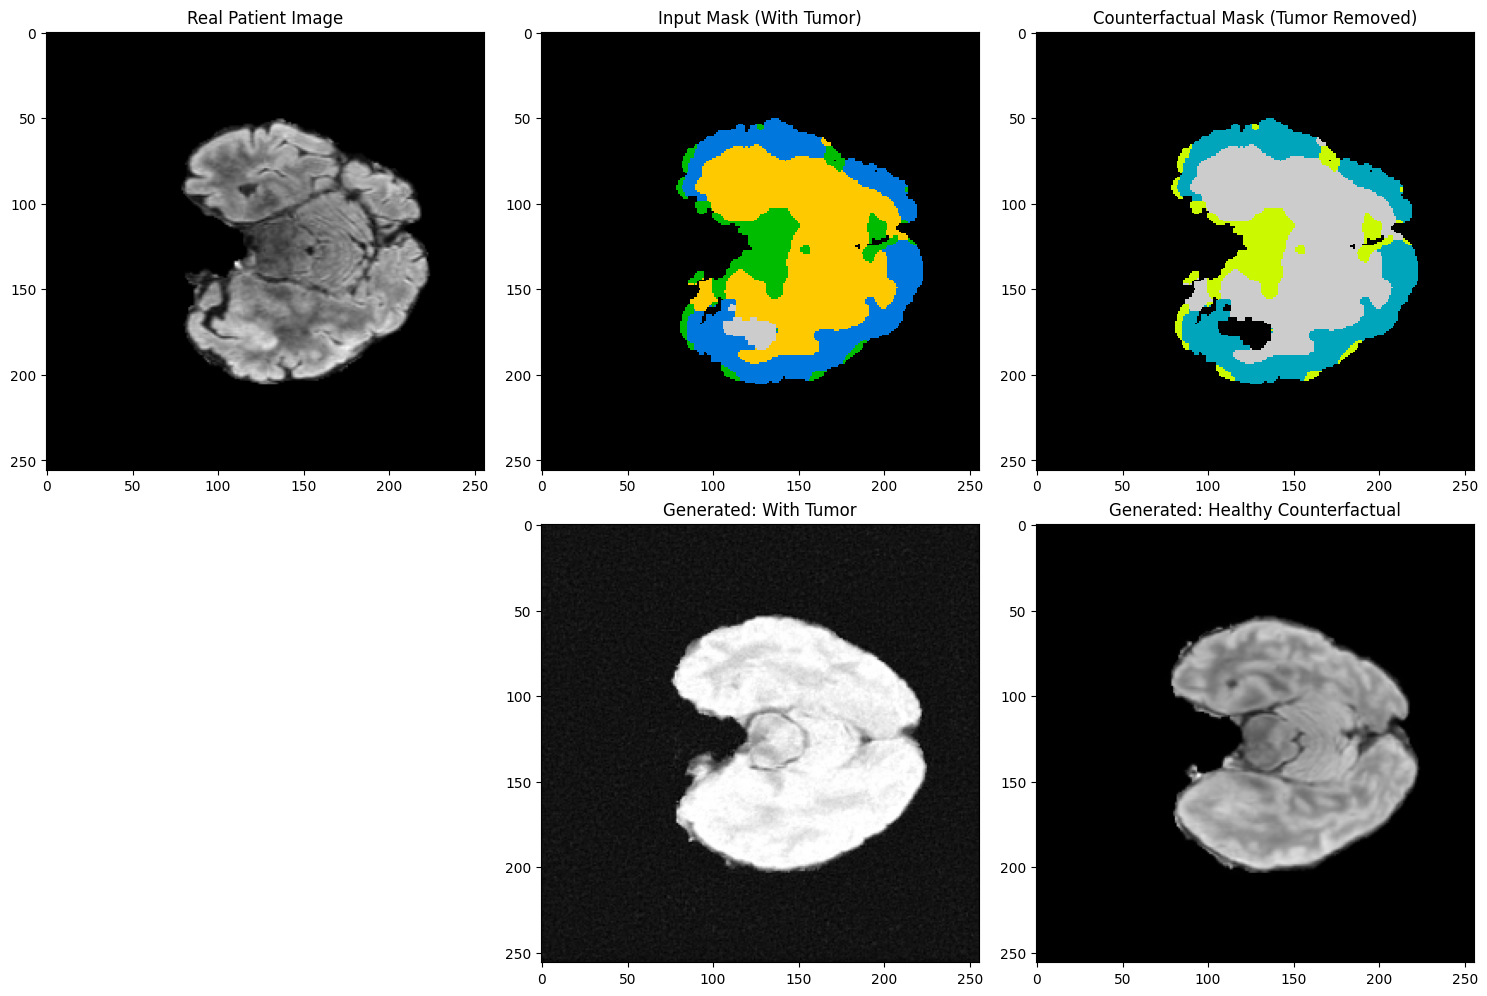

In [ ]:
# --- CELL 8: Generate Counterfactuals (Random Tumor Sample) ---
import torch
import matplotlib.pyplot as plt
import os
import wandb
import random
import numpy as np
from diffusers import DDPMPipeline, UNet2DModel, DDPMScheduler
from diffusers import DDIMScheduler
from tqdm.auto import tqdm
from safetensors.torch import load_file as load_safetensors

# 1. Find the Run using the API
print("Searching WandB for the latest run...")
api_run = find_latest_wandb_run(config)

if api_run is None:
    # Fallback to local if no run found (e.g. if you just finished training locally)
    print("No WandB run found. Checking local output dir...")
    if os.path.exists(os.path.join(config.OUTPUT_DIR, "checkpoint-latest")):
        artifact_dir = os.path.join(config.OUTPUT_DIR, "checkpoint-latest")
        print(f"Using local checkpoint: {artifact_dir}")
    else:
        raise ValueError("No previous run found on WandB or Local Disk!")
else:
    print(f"Target Run: {api_run.name} ({api_run.id})")
    artifacts = api_run.logged_artifacts()
    model_artifacts = [a for a in artifacts if a.type == "model"]
    if not model_artifacts:
        raise ValueError("No model artifacts found in this WandB run!")
    latest_artifact = sorted(model_artifacts, key=lambda x: x.updated_at)[-1]
    print(f"Downloading latest checkpoint from cloud: {latest_artifact.name}")
    artifact_dir = latest_artifact.download()

unet_dir = os.path.join(artifact_dir, "unet")

# 2. Initialize Model Structure
device = "cuda" if torch.cuda.is_available() else "cpu"

in_channels = 1 + (1 if config.segmentation_guided else 0)
unet = UNet2DModel(
    sample_size=config.image_size,
    in_channels=in_channels,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D", "UpBlock2D"),
)

# 3. Load Weights
state_dict = None
safe_path = os.path.join(unet_dir, "diffusion_pytorch_model.safetensors")
if os.path.exists(safe_path):
    state_dict = load_safetensors(safe_path)
else:
    bin_path = os.path.join(unet_dir, "diffusion_pytorch_model.bin")
    if os.path.exists(bin_path):
        state_dict = torch.load(bin_path, map_location="cpu", weights_only=False)

if state_dict is None:
    raise FileNotFoundError("Could not find model weights.")

# Handle unwrapping if needed
if "module." in list(state_dict.keys())[0]:
    print("Correcting DataParallel keys...")
    new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    state_dict = new_state_dict

unet.load_state_dict(state_dict)
unet.to(device)
unet.eval()

scheduler = DDPMScheduler(num_train_timesteps=1000)
# scheduler = DDIMScheduler(num_train_timesteps=1000)
# scheduler.set_timesteps(50) # DDIM handles 50 steps perfectly
print("Model loaded successfully!")

# 4. Helper for Sampling
def generate_with_mask(unet, scheduler, mask_tensor, steps=50):
    generator = torch.Generator(device='cpu').manual_seed(random.randint(0, 10000)) # Random seed for noise
    image = torch.randn(1, 1, config.image_size, config.image_size, generator=generator).to(device)
    scheduler.set_timesteps(steps)

    for t in tqdm(scheduler.timesteps, desc="Sampling"):
        model_input = torch.cat([image, mask_tensor], dim=1)
        with torch.no_grad():
            noise_pred = unet(model_input, t).sample
        image = scheduler.step(noise_pred, t, image).prev_sample
    return image

# 5. Pick a RANDOM Validation Sample (With Tumor)
from copy import deepcopy
val_config_safe = deepcopy(config)
val_config_safe.use_ablated_segmentations = False
val_ds = BraTSDataset(config.VAL_IMG_DIR, config.VAL_MASK_DIR, val_config_safe)

print("Scanning validation set for tumor slices (this may take a moment)...")
tumor_indices = []
# Limit scan to first 200 to be fast, or scan all if you want variety
scan_limit = min(len(val_ds), 500)

for i in range(scan_limit):
    m = val_ds[i]["seg_mask"]
    # Check if channel 4 (Tumor) has values > 0
    if m[0].max() > 0.015:
        tumor_indices.append(i)

if not tumor_indices:
    print("No tumor slices found! Using index 0.")
    sample_idx = 0
else:
    sample_idx = random.choice(tumor_indices)
    print(f"Found {len(tumor_indices)} tumor slices. Selected Index: {sample_idx}")

print(f"Generating for Validation Sample {sample_idx}...")
batch = val_ds[sample_idx]
real_img = batch["images"].unsqueeze(0).to(device)
real_mask = batch["seg_mask"].unsqueeze(0).to(device)

# 6. Create Counterfactual Mask
healthy_mask = real_mask.clone()
tumor_pixels = (healthy_mask > 0.014)
healthy_mask[tumor_pixels] = 0

# 7. Generate!
print("Generating 'Tumor' version (Reconstruction)...")
gen_tumor = generate_with_mask(unet, scheduler, real_mask)

print("Generating 'Healthy' version (Counterfactual)...")
gen_healthy = generate_with_mask(unet, scheduler, healthy_mask)

# 8. Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

def norm_disp(img): return (img[0,0].cpu() / 2 + 0.5).clamp(0, 1)

# Row 1: Inputs
axes[0,0].imshow(norm_disp(real_img), cmap='gray')
axes[0,0].set_title("Real Patient Image")
axes[0,1].imshow(real_mask[0,0].cpu(), cmap='nipy_spectral', interpolation='nearest')
axes[0,1].set_title("Input Mask (With Tumor)")
axes[0,2].imshow(healthy_mask[0,0].cpu(), cmap='nipy_spectral', interpolation='nearest')
axes[0,2].set_title("Counterfactual Mask (Tumor Removed)")

# Row 2: Outputs
axes[1,0].axis('off')
axes[1,1].imshow(norm_disp(gen_tumor), cmap='gray')
axes[1,1].set_title("Generated: With Tumor")
axes[1,2].imshow(norm_disp(gen_healthy), cmap='gray')
axes[1,2].set_title("Generated: Healthy Counterfactual")

plt.tight_layout()
plt.show()